# SMOTE - Oversampling
Sep 18, 2020

In [1]:
import os, glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

plt.style.use('seaborn')
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

%matplotlib inline

## Track 1

mrc_info: 온라인 가맹점 업종 정보  
samp_train: 회원의 1월달 온라인 가맹점 이용여부 데이터  
samp_cst_feat: 회원 특성 정보  
variable_dtype: 변수 데이터 타입 정보(메타 데이터)  

In [4]:
pathList = glob.glob('../raw/*')
for idx, p in enumerate(pathList[:4]):
    name = p.split(' ')[-1].split('.')[0]
    print(f'Load {name}')
    if idx < 3:
        globals()[name] = pd.read_csv(p, engine='python')
    else:
        globals()[name] = pd.read_excel(p)

Load mrc_info
Load samp_train
Load samp_cst_feat
Load variable_dtype


### samp_train
회원의 1월달 온라인 가맹점 이용여부 데이터
  
  
  
<u>Description</u>  
> cst_id_di: 고객관리번호(고객 식별 ID)  
MRC_ID_DI: 온라인 가맹점 번호(0: 온라인 가맹점 미이용)

#### 온라인 가맹점 별 고객 이용 Frequency

Text(0.5, 0.98, '온라인 가맹점별 고객 이용 Frequency')

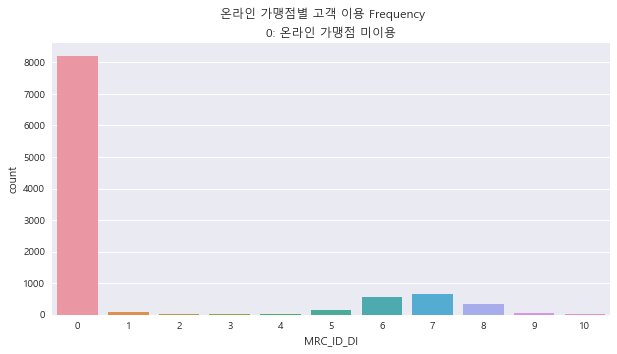

In [5]:
plt.figure(figsize=(10,5))
sns.countplot('MRC_ID_DI', data=samp_train)
plt.title('0: 온라인 가맹점 미이용')
plt.suptitle('온라인 가맹점별 고객 이용 Frequency')

Text(0.5, 0.98, '온라인 가맹점 이용 여부 Frequency')

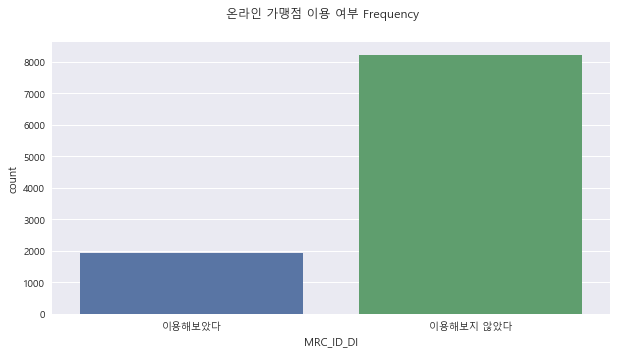

In [6]:
plt.figure(figsize=(10,5))
sns.countplot((samp_train['MRC_ID_DI'] == 0))
plt.xticks([0, 1], ['이용해보았다', '이용해보지 않았다'])
plt.suptitle('온라인 가맹점 이용 여부 Frequency')

온라인 가맹점을 사용해보지 않은 고객이 압도적으로 많음  
=> 불균형 데이터에 대해 Oversampling 필요

가맹점 이용 빈도 수는 7 > 6 >> 8 >> 5 ... 순으로 높다

## SMOTE 기법을 활용한 Oversampling

- SMOTE 개요
![SMOTE](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png)

## SMOTE 이전의 모델 성능 평가

In [16]:
df = samp_cst_feat.merge(samp_train,on='cst_id_di')

In [35]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=10)
#모델링
def modeling(model,x_train,x_test,y_train,y_test):
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    metrics(y_test,pred)
#평가 지표
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
def metrics(y_test,pred):
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred,average='micro')
    recall = recall_score(y_test,pred,average='micro')
    f1 = f1_score(y_test,pred,average='micro')

    print('정확도 : {0:.2f}, 정밀도 : {1:.2f}, 재현율 : {2:.2f}'.format(accuracy,precision,recall))

### 로지스틱 모델 

In [36]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
modeling(lr,X_train,X_test,y_train,y_test)

정확도 : 0.81, 정밀도 : 0.81, 재현율 : 0.81


### Light gbm 모델

In [48]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(n_estimators=100,n_jobs=-1,boost_from_average=False,random_state=1)
modeling(lgb,X_train,X_test,y_train,y_test)

정확도 : 0.80, 정밀도 : 0.80, 재현율 : 0.80


## SMOTE 적용 후 모델 평가

In [94]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_sample(X_train,y_train)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts(ascending=True))

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (7593, 227) (7593,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (67771, 227) (67771,)
SMOTE 적용 후 레이블 값 분포: 
 0     6161
1     6161
2     6161
3     6161
4     6161
5     6161
6     6161
7     6161
8     6161
9     6161
10    6161
Name: MRC_ID_DI, dtype: int64


### 분포 변화 살펴보기

Text(0.5, 0.98, '  불균형 데이터 처리 by SMOTE')

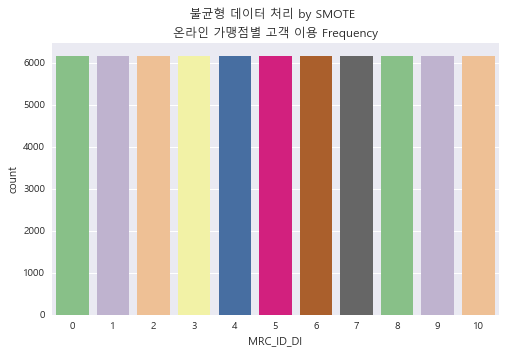

In [81]:
plt.figure(figsize=(8,5))
sns.countplot(y_train_over,palette='Accent')
plt.title('온라인 가맹점별 고객 이용 Frequency')
plt.suptitle('  불균형 데이터 처리 by SMOTE')

### 로지스틱 모델 SMOTE

In [91]:
lr = LogisticRegression()
modeling(lr,X_train_over,X_test,y_train_over,y_test)

정확도 : 0.00, 정밀도 : 0.00, 재현율 : 0.00


In [90]:
lgb = LGBMClassifier(n_estimators=100,num_leaves=64,n_jobs=-1,boost_from_average=False)
modeling(lgb,X_train_over,X_test,y_train_over,y_test)

정확도 : 0.79, 정밀도 : 0.79, 재현율 : 0.79


..? 왜..?